### Home task

Find the public dataset and apply collaborative filtering recommendation

In [207]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

In [208]:
file_path = 'songsDataset.csv'
with open(file_path, 'r') as file:
    df = pd.read_csv(file)

In [209]:
df_song = df.head(2000)
df_song

,'userID','songID','rating'
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5
...,...,...,...
1995,199,46153,3
1996,199,52770,4
1997,199,70720,3
1998,199,87486,3


In [210]:
df_song.columns = ['userID', 'songID', 'rating']

In [211]:
df_target = df_song.pivot(index="userID", columns="songID", values="rating")
df_target.head()

songID,107,208,259,319,345,413,568,578,605,619,...,135789,135792,136076,136196,136270,136406,136449,136479,136507,136571
userID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


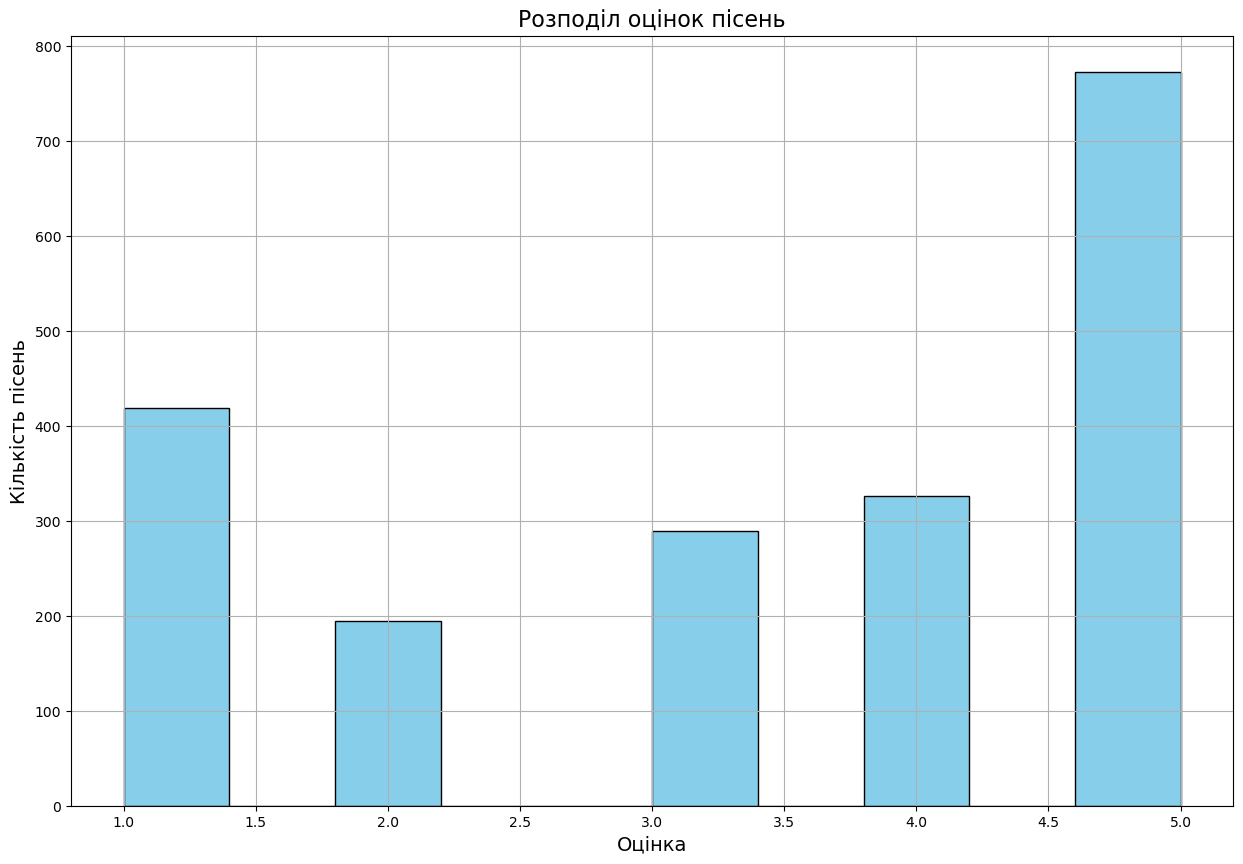

In [212]:
plt.figure(figsize = (15,10))
df_song["rating"].hist(color = 'skyblue', edgecolor = 'black')
plt.title('Розподіл оцінок пісень', fontsize=16)
plt.xlabel('Оцінка', fontsize=14)
plt.ylabel('Кількість пісень', fontsize=14)
plt.show()

### Predict 

In [213]:
Y = df_song.fillna(0)
R = df_song.applymap(lambda x: 0 if np.isnan(x) else 1)
print(Y.shape)
scale = Y.max() - Y.min()
Y_scaled = Y / scale * 4
Y_scaled


(2000, 3)


,userID,songID,rating
0,0.0,0.210195,5.0
1,0.0,0.253166,4.0
2,0.0,0.643862,4.0
3,0.0,1.049977,5.0
4,0.0,2.416637,5.0
...,...,...,...
1995,4.0,1.352826,3.0
1996,4.0,1.546782,4.0
1997,4.0,2.072928,3.0
1998,4.0,2.564369,3.0


## Collaborative Filtering Cost Function


In [214]:
def J(Y, R, X, Theta, lambd):
    assert X.shape[1] == Theta.shape[0]
    h = np.dot(X, Theta)
    error = np.power(h - Y, 2)
    reg = lambd / 2 * (np.sum(np.power(X, 2)) + np.sum(np.power(Theta, 2)))
    J = np.sum(error * R) + reg
    return J

## Collaborative Filtering Cost Function Gradient


In [215]:
def J_derivative(Y,R,X, Theta, num_movies, num_users, num_features, lambd): 
    cost_matr = (X @ Theta - Y) * R
    X_grad = cost_matr @ Theta.T
    Theta_grad = (cost_matr.T @ X).T
    assert X_grad.shape == X.shape
    assert Theta_grad.shape == Theta.shape
    X_grad += lambd * X
    Theta_grad += lambd * Theta
    return X_grad, Theta_grad

## Gradient descent (`fit`)

In [216]:
def fit(Y,R, num_features= 10,  alpha=0.0001, lambd= .01, eps= .1,  max_iter=1000,step=100, verbose=0):    
    num_movies,num_users =Y.shape
    
    
    if verbose: 
        print ('Running gradient descent with alpha= {}, lambda= {}, eps= {}, max_iter= {}'.format(
            alpha, lambd, eps, max_iter))
        

    #     X= params[:num_movies*num_features].reshape(num_movies,num_features)
    #     Theta = params[num_movies*num_features:].reshape(num_features,num_users)

    np.random.seed(2019)
    X = np.random.randn(num_movies, num_features)
    Theta = np.random.randn( num_features, num_users)
    
    J_hist=[-1] # used for keeping J values. Init with -1 to avoid 0 at first iter
    continue_iter = True # flag to continue next iter (grad desc step)
    iter_number =0 # used for limit by max_iter

    while continue_iter:            
        # Do step of gradient descent    
        X_grad, Theta_grad =  J_derivative(Y,R,X, Theta, num_movies, num_users, num_features, lambd)
        X= X- alpha  *X_grad        
        Theta= Theta- alpha  *Theta_grad

        # keep history of J values
        J_hist.append(J(Y, R, X,Theta, lambd))
        # check criteria of exit (finish grad desc)
        if iter_number> max_iter: # if limit succeeded
            continue_iter = False
            print ('iter_number> max_iter')
        elif np.abs(J_hist[iter_number-1] - J_hist[iter_number])< eps: # if accuracy is succeeded
            continue_iter = False
            print ('J_hist[iter_number]={}'.format(J_hist[iter_number]))
        iter_number += 1
        
        if verbose and iter_number%step ==0:
            print ('{}: {}'.format(iter_number, J_hist[iter_number-1]))
    
    return X,Theta, J_hist

### Train model

In [217]:
params = (Y_scaled.values, R.values)
params_kwargs = {
    'num_features': 20,
    'alpha': 0.0005,
    'lambd': 1,
    'max_iter': 2000,
    'eps': 0.01,
    'step': 50,
    'verbose': 1
}
X, Theta, J_hist = fit(*params, **params_kwargs)


Running gradient descent with alpha= 0.0005, lambda= 1, eps= 0.01, max_iter= 2000
50: 67460.02523921987
100: 63720.42757173783
150: 55151.88972461493
200: 40566.82301627667
250: 28115.22803092299
300: 22574.120841264157
350: 20554.36519975737
400: 19564.061291528604
450: 18832.177585726058
500: 18174.926646682474
550: 17552.08856483276
600: 16953.944496340395
650: 16376.520549339744
700: 15816.63934461738
750: 15270.964909123237
800: 14735.77731399579
850: 14206.873033844782
900: 13679.504308902531
950: 13148.372656194411
1000: 12607.723756120093
1050: 12051.61201806313
1100: 11474.412269582968
1150: 10871.633210403597
1200: 10241.005365415815
1250: 9583.664755936486
1300: 8905.079601369707
1350: 8215.2956005185
1400: 7528.231149280074
1450: 6860.098100067705
1500: 6227.311019502421
1550: 5644.292807668956
1600: 5121.520986275698
1650: 4664.200350475985
1700: 4271.969683287273
1750: 3939.774373115385
1800: 3659.5521989146955
1850: 3422.087946306174
1900: 3218.4919179161466
1950: 3041.0

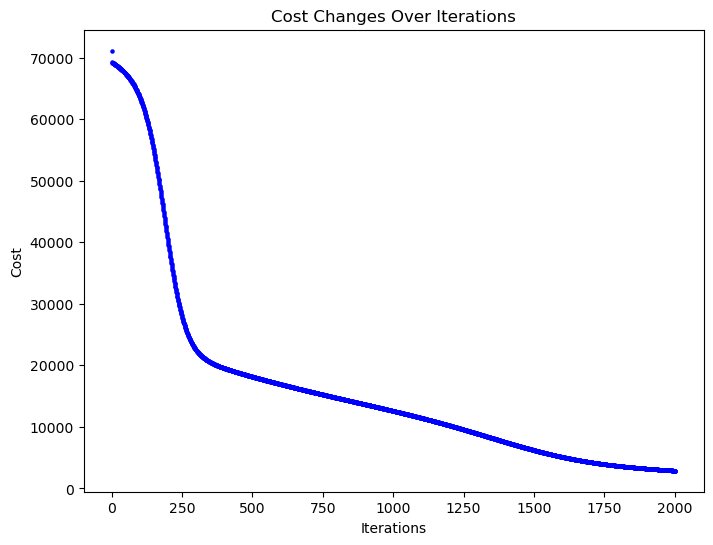

In [218]:
def draw_cost_changes(J_hist):
    iterations = np.arange(1, len(J_hist))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(iterations, J_hist[1:], s=20, marker='.', c='b')
    plt.title('Cost Changes Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()
draw_cost_changes(J_hist)


In [219]:
pred = X @ Theta
prediction_df = pd.DataFrame(pred)
prediction_df

,0,1,2
0,0.041548,0.199833,4.962939
1,0.059108,0.246292,3.956570
2,0.023672,0.562770,4.014348
3,-0.137324,1.132223,5.008310
4,0.074495,2.346878,4.972476
...,...,...,...
1995,3.969332,1.370028,2.982053
1996,4.070213,1.442310,3.988407
1997,3.950328,2.078724,2.998754
1998,3.801494,2.658509,3.032664


In [221]:
diff_train = np.array(pred - Y)
max_diff = np.abs(diff_train).max()
mean_diff = np.abs(diff_train).mean()
print('Training:')
print('Max difference:', max_diff)
print('Mean difference:', mean_diff)

Training:
Max difference: 136567.1231593775
Mean difference: 22959.690896557153
